# Experiments with Python code in Doc2Vec

In [1]:
import multiprocessing
from pathlib import Path
import ast
import astor
import tokenize
import io

import gensim.models.doc2vec
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"


In [2]:
test_code_dir = Path('test_data')
train_code_dir = Path('training_data')
models_dir = Path('models')

In [3]:
def split_methods(code):
    """Parse Python files into separate methods

        :param code: Python code to parse.
        :rtype: list
    """
    funcs = []
    try:
        tree = ast.parse(code)
        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                func = astor.to_source(node)
                funcs.append(func)
    except:
        pass

    if not funcs:
        funcs = code  # just send everything back
    return funcs

In [4]:
def read_train_corpus():
    count = 0
    for i, file in enumerate(train_code_dir.glob('./python_projects/**/*.py')):
        if not file.is_file():  # oddly, some of these are not files
            continue
        with file.open() as f:
            try:
                code = f.read()
                methods = split_methods(code)
                for method in methods:
                    tokens = list(tokenize.generate_tokens(io.StringIO(method).readline))
                    tokens = [token for t in tokens if t.type == tokenize.NAME or t.type == tokenize.OP for token in t.string.split(" ")]
                    if tokens:
                        tag = "Python_%s" % count
                        count += 1
                        source = "github"
                        path = file.__fspath__()
                        yield TaggedDocument(tokens, [tag, source, path])
                        
            except tokenize.TokenError as te:
                # print("%s: %s" % (type(te).__name__, te.args))
                pass
            except UnicodeDecodeError as e:
                # print("%s: %s" % (type(e).__name__, e))
                pass
            except Exception as e:
                print("%s: %s" % (type(e).__name__, e))
                pass
     
        if i % 10000 == 0:
            print("Processed %s records" % i)
        if i > 25000:
            break
            
    # also include test corpus in training! 
    for programming_language in test_code_dir.glob('./Python'):
        if not programming_language.is_dir():
            continue
        for programming_task in programming_language.glob('./*'):
            if not programming_task.is_dir():
                continue
            for implementation in programming_task.glob('./*'):
                with implementation.open() as f:
                    try:
                        code = f.read()  # don't split rosetta files into methods; learn them as a single vector
                        tokens = list(tokenize.generate_tokens(io.StringIO(code).readline))
                        tokens = [token for t in tokens if t.type == tokenize.NAME or t.type == tokenize.OP for token in t.string.split(" ")]
                        if tokens:
                            tag = "Python_%s" % count
                            count += 1
                            source = "rosetta"
                            path = file.__fspath__()
                            yield TaggedDocument(tokens, [tag, source, path])
                    except tokenize.TokenError as e:
                        # print("%s: %s" % (type(e).__name__, e))
                        pass
                    except IndentationError as e:
                        # print("%s: %s" % (type(e).__name__, e))
                        pass
                    except Exception as e:
                        print("%s: %s" % (type(e).__name__, e))
                        pass


%time train_corpus = list(read_train_corpus())
print("Training corpus size: %s" % len(train_corpus))


Processed 0 records


Processed 10000 records


Processed 20000 records


CPU times: user 5min 53s, sys: 13 s, total: 6min 6s
Wall time: 6min 20s
Training corpus size: 1329283


In [5]:
def read_test_corpus():
    color_val = 0
    for programming_language in test_code_dir.glob('./Python'):
        if not programming_language.is_dir():
            continue
        for programming_task in programming_language.glob('./*'):
            if not programming_task.is_dir():
                continue
            color_val += 1
            for implementation in programming_task.glob('./*'):
                with implementation.open() as f:
                    try:
                        code = f.read()
                        tokens = list(tokenize.generate_tokens(io.StringIO(code).readline))
                        tokens = [token for t in tokens if t.type == tokenize.NAME or t.type == tokenize.OP for token in t.string.split(" ")]
                        if tokens:
                            # print("Task: %s; Color: %s" % (programming_task.name, color_val))
                            yield TaggedDocument(tokens, [programming_task.name, implementation.name, programming_language.name, color_val])
                    except tokenize.TokenError as e:
                        # print("%s: %s" % (type(e).__name__, e))
                        pass
                    except IndentationError as e:
                        # print("%s: %s" % (type(e).__name__, e))
                        pass
                    except Exception as e:
                        print("%s: %s" % (type(e).__name__, e))
                        pass

              
test_corpus = list(read_test_corpus())
print("Test corpus size: %s" % len(test_corpus))

Test corpus size: 659


In [6]:
# doc2vec parameters
vector_size = 100
window_size = 8
min_count = 5
sampling_threshold = 1e-5
negative_size = 5
epochs = 20
dm = 0  # 0 = dbow; 1 = dmpv
worker_count = multiprocessing.cpu_count()  # number of parallel processes

In [7]:
%%time
model = Doc2Vec(train_corpus,
                vector_size=vector_size,
                window=window_size,
                min_count=min_count,
                sample=sampling_threshold,
                negative=negative_size,
                dbow_words=1,
                epochs=epochs,
                dm=dm,
                workers=worker_count)


CPU times: user 45min 5s, sys: 18min 12s, total: 1h 3min 17s
Wall time: 36min 28s


In [8]:
model.save(str(models_dir / "github-python-vectors.bin"))

In [9]:
model.wv.most_similar('i')

[('range', 0.8244612812995911),
 ('enumerate', 0.7829285264015198),
 ('-', 0.7773046493530273),
 ('j', 0.7720720171928406),
 ('len', 0.7187677025794983),
 ('for', 0.7073608636856079),
 ('+', 0.704919159412384),
 ('+=', 0.6931743621826172),
 ('<', 0.6733689308166504),
 ('in', 0.6727164387702942)]

In [10]:
model.wv.most_similar('count')

[('quick', 0.5466387867927551),
 ('+=', 0.543124258518219),
 ('all', 0.5206875801086426),
 ('count2', 0.5194403529167175),
 ('snap_meta_rows', 0.5166100859642029),
 ('FooAccount', 0.5161308646202087),
 ('size_g', 0.5117737054824829),
 ('sporadic', 0.5104818940162659),
 ('snap_rows', 0.507519006729126),
 ('vol_type_proj_rows', 0.503285825252533)]

In [12]:
docs = [{'name': doc.tags[0], 'vec': model.infer_vector(doc.words, steps=200), 'color': doc.tags[3]} for doc in test_corpus]
num_colors = docs[-1]['color']

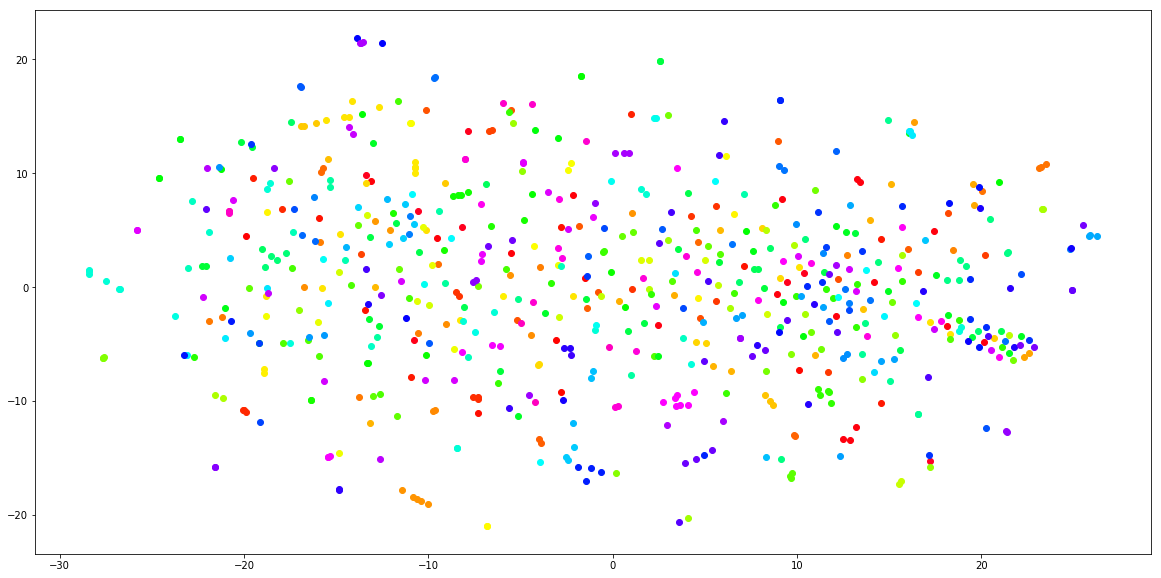

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import matplotlib
from sklearn.manifold import TSNE

matplotlib.rcParams['figure.figsize'] = (20, 10)

tsne = TSNE(n_components=2)
twoDimVecs = tsne.fit_transform([doc['vec'] for doc in docs])

cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=num_colors-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots()
for doc, twoDimVec in zip(docs, twoDimVecs):
    ax.scatter(twoDimVec[0], twoDimVec[1], color=scalarMap.to_rgba(doc['color']))
plt.show()